

# **Final Submission**

For the capstone project I choose to compare the actual models using some of transfer learning using the VGG16 and Resnet to compare with an aritificial neural network implemented from scratch as the dataset selected for this task is small.
Morover as it can see in the project notebook, one of the transfer learning model, the resnet, did not perform so well with scores less than 0.50, as VGG16 did not too, eventhought the resnet model implementation was adapted to the data input that we have to see if the resnet can converge and show some valid performance at least but it did not.
On the other hand our ANN model , the model3 we keep training and modifying to increase its performance it performs better and using the Bayessian Optimization to tune the learning rate hyperparameter, we could great a far better metrics as an accuracy greater than 0.95
And finally we compare the 3 models in this notebook to choose the best performance one that it was the ANN.
**Note:** We will mount our drive and import our dataset.

## **Mounting the Drive**

**NOTE:**  **We use colab pro for speed up the training of the models and compare the performance evaluation.**

In [1]:
gpu_info = !nvidia-smi  #identifying the GPU available in Colab
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 31 04:45:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [4]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  print(
#      '\n\nThis error most likely means that this notebook is not '
#      'configured to use a GPU.  Change this in Notebook Settings via the '
#      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#  raise SystemError('GPU device not found')


# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load the data**

In [5]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architecture**

In this section, we will use the Learning architecture that worked the best performance between the other as resnet and VGG16 to see how they perform. For the pre-trained models, it was selected these 2 as they are good for visual imaging but only vgg16 could deliver some stable result but not enough.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will use DataImageGenerator from Keras, we will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures and we modify the batch_size and the img_size.

In [7]:
batch_size  = 48
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

##datagen_validation = # Write your code here

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)  # Write your code here

#validation_set = # Write your code here

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb', # Provide your chosen color_mode here ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)  # Write your code here


##datagen_test = # Write your code here

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3) # Write your code here

##test_set = # Write your code here

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb', # Provide your chosen color_mode here ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True) # Write your code here






Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 and Resnet Model**

### **Importing the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

######################################################

# Clearing backend

from tensorflow.keras import backend

backend.clear_session()
# Fixing the seed for random number generators

np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

#######################################################

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. We can scroll down in the model summary and look for 'block5_pool'. We will choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False

# Add classification layers on top of it
#____________

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)


# Add a DropOut layer with Drop out ratio of 0.3
#____________
x = Dropout(0.3)(x)



# Add a Batch Normalization layer
#____________
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Compiling and Training the VGG16 Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 200

**Note:** **For training different learning rates were selected to compare the performance, we tried with 0.005, 0.0002, 0.0008 and 0.00075**

In [ ]:
# Writing code to compile the vggmodel. Using categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'.

opt = tf.keras.optimizers.Adam(learning_rate=0.00075)
vggmodel.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
backend.clear_session()

In [ ]:
history_vgg_model =  vggmodel.fit(train_set,
        steps_per_epoch=50,
        epochs=epochs,
        validation_data=validation_set,
        validation_steps=50
        )# Writing code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 200 epochs.


Epoch 1/200
50/50 [==============================] - 7s 126ms/step - loss: 1.0653 - accuracy: 0.5362 - val_loss: 1.2920 - val_accuracy: 0.4125
Epoch 2/200
50/50 [==============================] - 6s 120ms/step - loss: 1.0484 - accuracy: 0.5496 - val_loss: 1.3213 - val_accuracy: 0.3875
Epoch 3/200
50/50 [==============================] - 6s 120ms/step - loss: 1.0718 - accuracy: 0.5392 - val_loss: 1.2618 - val_accuracy: 0.4179
Epoch 4/200
50/50 [==============================] - 6s 119ms/step - loss: 1.0810 - accuracy: 0.5308 - val_loss: 1.2820 - val_accuracy: 0.4092
Epoch 5/200
50/50 [==============================] - 6s 121ms/step - loss: 1.0684 - accuracy: 0.5317 - val_loss: 1.2630 - val_accuracy: 0.4142
Epoch 6/200
50/50 [==============================] - 6s 120ms/step - loss: 1.0769 - accuracy: 0.5367 - val_loss: 1.2534 - val_accuracy: 0.4162
Epoch 7/200
50/50 [==============================] - 6s 120ms/step - loss: 1.0706 - accuracy: 0.5263 - val_loss: 1.2797 - val_accuracy: 0.4075

KeyboardInterrupt: ignored

### **Evaluating the VGG16 model**

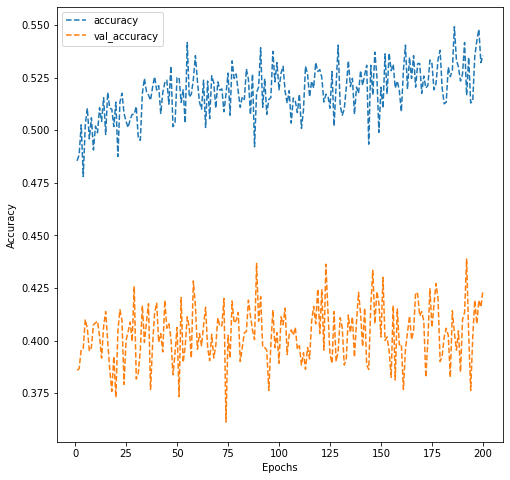

In [ ]:
# Code to evaluate model performance on the test set
# Plotting the accuracies

dict_hist = history_vgg_model.history

list_ep = [i for i in range(1, 201)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
test_pred_vgg16 = vggmodel.predict(test_set)
test_pred_vgg16_classes = np.argmax(test_pred_vgg16, axis=1)

3/3 [==============================] - 0s 106ms/step


In [ ]:
vggmodel.save('/content/drive/MyDrive/Models')

In [ ]:
test_pred_vgg16_classes

array([0, 2, 1, 2, 1, 3, 0, 1, 3, 0, 2, 0, 2, 3, 2, 1, 0, 0, 1, 2, 2, 3,
       1, 1, 0, 1, 0, 1, 0, 3, 1, 2, 2, 0, 1, 3, 0, 2, 1, 1, 3, 3, 2, 2,
       0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 3, 0, 2, 2, 1, 1, 1, 3,
       2, 1, 0, 3, 2, 3, 3, 3, 0, 1, 1, 3, 0, 2, 2, 2, 0, 2, 0, 1, 1, 3,
       1, 3, 0, 1, 3, 1, 0, 2, 1, 0, 3, 3, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       3, 1, 0, 2, 1, 2, 1, 0, 2, 1, 3, 0, 1, 1, 3, 3, 0, 2])

              precision    recall  f1-score   support

           0       0.24      0.28      0.26        32
           1       0.19      0.22      0.20        32
           2       0.24      0.22      0.23        32
           3       0.25      0.19      0.21        32

    accuracy                           0.23       128
   macro avg       0.23      0.23      0.23       128
weighted avg       0.23      0.23      0.23       128



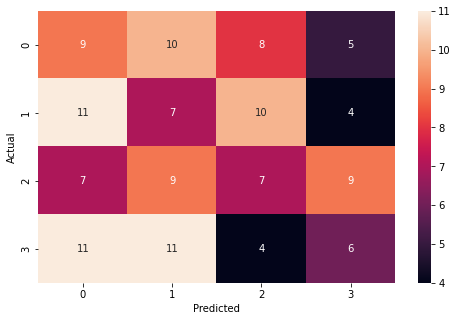

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

true_classes_vgg16 = test_set.classes
class_labels_vgg16 = list(test_set.class_indices.keys())

# Printing the classification report

print(classification_report(true_classes_vgg16, test_pred_vgg16_classes))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(true_classes_vgg16, test_pred_vgg16_classes)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f')

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()


**Observations and Insights:** **For the VGG model now tested with 3 channel the performance not improve as we got as an average of 0.41 in the accuracy, it was tested again with one channel but the accuracy was close to the same, so the VGG model did not make any major improve at the end, so the vgg model for this set will not be considered as a final model solution. It was supposed to use the vgg model if improved to mix with the model3 to arrive to a final classification but the vgg model did not improve.**

### **ResNet Custom Model Implementation**
**In this part of the notebook it is implemented a resnet architecture based on the He et al. paper and adapted from a previous implementation to see if the resnet can converge and give a better performance. The input are processed as rgb for the input data for the model and as a grayscale too**

In [31]:
import os
import numpy as np
import tensorflow
from tensorflow.keras import Model
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, Flatten, Conv2D, Lambda,	Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [32]:
batch_size  = 32
img_size = 32

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

##datagen_validation = #

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)  #

#validation_set = #

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale', # Providing chosen color_mode here ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)  #


##datagen_test = #

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3) #

##test_set = #

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale', # Providing chosen color_mode here ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True) #





Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [33]:
def model_configuration():
	"""
		Get configuration variables for the model.
	"""

	# Load dataset for computing dataset size
#

	# Generic config
	width, height, channels = 32, 32, 1
	batch_size = 32
	num_classes = 4
	validation_split = 0.2
	verbose = 1
	n = 3
	init_fm_dim = 16
	shortcut_type = "identity" # or: projection

	# Dataset size
	train_size = (1 - validation_split) * 20000
	val_size = (validation_split) * 20000

	# Number of steps per epoch is dependent on batch size
	maximum_number_iterations = 64000
	steps_per_epoch = 50
	val_steps_per_epoch = tensorflow.math.floor(val_size / batch_size)
	epochs = 250

	# Defining loss function
	loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)

	# Learning rate config per the He et al. paper
	boundaries = [32000, 48000]
	values = [0.005, 0.001, 0.0001]
	lr_schedule = schedules.PiecewiseConstantDecay(boundaries, values)

	# Set layer init
	initializer = tensorflow.keras.initializers.HeNormal()

	# Define optimizer
	optimizer_momentum = 0.9
	optimizer_additional_metrics = ["accuracy"]
	optimizer = SGD(learning_rate=lr_schedule, momentum=optimizer_momentum)

	# Load Tensorboard callback
	tensorboard = TensorBoard(
	  log_dir=os.path.join(os.getcwd(), "logs"),
	  histogram_freq=1,
	  write_images=True
	)

	# Save a model checkpoint after every epoch
	checkpoint = ModelCheckpoint(
		os.path.join(os.getcwd(), "model_checkpoint"),
		save_freq="epoch"
	)

	# Add callbacks to list
	callbacks = [
	  tensorboard,
	  checkpoint
	]

	# Create config dictionary
	config = {
		"width": width,
		"height": height,
		"dim": channels,
		"batch_size": batch_size,
		"num_classes": num_classes,
		"validation_split": validation_split,
		"verbose": verbose,
		"stack_n": n,
		"initial_num_feature_maps": init_fm_dim,
		"training_ds_size": train_size,
		"steps_per_epoch": steps_per_epoch,
		"val_steps_per_epoch": val_steps_per_epoch,
		"num_epochs": epochs,
		"loss": loss,
		"optim": optimizer,
		"optim_learning_rate_schedule": lr_schedule,
		"optim_momentum": optimizer_momentum,
		"optim_additional_metrics": optimizer_additional_metrics,
		"initializer": initializer,
		"callbacks": callbacks,
		"shortcut_type": shortcut_type
	}

	return config

In [34]:
def residual_block(x, number_of_filters, match_filter_size=False):
	"""
		Residual block with
	"""
	# Retrieve initializer
	config = model_configuration()
	initializer = config.get("initializer")

	# Create skip connection
	x_skip = x

	# Perform the original mapping
	if match_filter_size:
		x = Conv2D(number_of_filters, kernel_size=(3, 3), strides=(2,2),\
			kernel_initializer=initializer, padding="same")(x_skip)
	else:
		x = Conv2D(number_of_filters, kernel_size=(3, 3), strides=(1,1),\
			kernel_initializer=initializer, padding="same")(x_skip)
	x = BatchNormalization(axis=3)(x)
	x = Activation("relu")(x)
	x = Conv2D(number_of_filters, kernel_size=(3, 3),\
		kernel_initializer=initializer, padding="same")(x)
	x = BatchNormalization(axis=3)(x)

	# Perform matching of filter numbers if necessary
	if match_filter_size and config.get("shortcut_type") == "identity":
		x_skip = Lambda(lambda x: tensorflow.pad(x[:, ::2, ::2, :], tensorflow.constant([[0, 0,], [0, 0], [0, 0], [number_of_filters//4, number_of_filters//4]]), mode="CONSTANT"))(x_skip)
	elif match_filter_size and config.get("shortcut_type") == "projection":
		x_skip = Conv2D(number_of_filters, kernel_size=(1,1),\
			kernel_initializer=initializer, strides=(2,2))(x_skip)

	# Add the skip connection to the regular mapping
	x = Add()([x, x_skip])

	# Nonlinearly activate the result
	x = Activation("relu")(x)

	# Return the result
	return x

In [35]:
def ResidualBlocks(x):
	"""
		Set up the residual blocks.
	"""
	# Retrieve values
	config = model_configuration()

	# Set initial filter size
	filter_size = config.get("initial_num_feature_maps")

	# Paper: "Then we use a stack of 6n layers (...)
	#	with 2n layers for each feature map size."
	# 6n/2n = 3, so there are always 3 groups.
	for layer_group in range(3):

		# Each block in our code has 2 weighted layers,
		# and each group has 2n such blocks,
		# so 2n/2 = n blocks per group.
		for block in range(config.get("stack_n")):

			# Perform filter size increase at every
			# first layer in the 2nd block onwards.
			# Apply Conv block for projecting the skip
			# connection.
			if layer_group > 0 and block == 0:
				filter_size *= 2
				x = residual_block(x, filter_size, match_filter_size=True)
			else:
				x = residual_block(x, filter_size)

	# Return final layer
	return x

In [36]:
def model_base(shp):
	"""
		Base structure of the model, with residual blocks
		attached.
	"""
	# Get number of classes from model configuration
	config = model_configuration()
	initializer = model_configuration().get("initializer")

	# Define model structure
	# logits are returned because Softmax is pushed to loss function.
	inputs = Input(shape=shp)
	x = Conv2D(config.get("initial_num_feature_maps"), kernel_size=(3,3),\
		strides=(1,1), kernel_initializer=initializer, padding="same")(inputs)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)
	x = ResidualBlocks(x)
	x = GlobalAveragePooling2D()(x)
	x = Flatten()(x)
	outputs = Dense(config.get("num_classes"), kernel_initializer=initializer)(x)

	return inputs, outputs

In [37]:
def init_model():
	"""
		Initialize a compiled ResNet model.
	"""
	# Get shape from model configuration
	config = model_configuration()

	# Get model base
	inputs, outputs = model_base((config.get("width"), config.get("height"),\
		config.get("dim")))

	# Initialize and compile model
	model = Model(inputs, outputs, name=config.get("name"))
	model.compile(loss=config.get("loss"),\
				  optimizer=config.get("optim"),\
				  	metrics=config.get("optim_additional_metrics"))

	# Print model summary
	model.summary()

	return model

In [38]:
def train_model(model, train_batches, validation_batches):
	"""
		Train an initialized model.
	"""

	# Get model configuration
	config = model_configuration()

	# Fit data to model
	model.fit(train_batches,
	          batch_size=config.get("batch_size"),
	          epochs=config.get("num_epochs"),
	          verbose=config.get("verbose"),
	          callbacks=config.get("callbacks"),
	          steps_per_epoch=config.get("steps_per_epoch"),
	          validation_data=validation_batches,
	          validation_steps=config.get("val_steps_per_epoch"))

	return model

In [39]:
def evaluate_model(model, test_batches):
	"""
		Evaluate a trained model.
	"""
	# Evaluate model
	score = model.evaluate(test_batches, verbose=0)
	print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [40]:
def training_process():
	"""
		Run the training process for the ResNet model.
	"""

	# Get dataset
	#train_batches, validation_batches, test_batches = preprocessed_dataset()

	train_batches = train_set
	validation_batches = validation_set
	test_batches = test_set

	# Initialize ResNet
	resnet = init_model()

	# Train ResNet model
	trained_resnet = train_model(resnet, train_batches, validation_batches)

	# Evalute trained ResNet model post training
	evaluate_model(trained_resnet, test_batches)

In [41]:
######################################################

# Clearing backend

from tensorflow.keras import backend

backend.clear_session()


#######################################################

In [42]:
	# Initialize ResNet
	resnet = init_model()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [43]:
	train_batches = train_set
	validation_batches = validation_set
	test_batches = test_set

In [44]:
trained_resnet = train_model(resnet, train_batches, validation_batches)

Epoch 1/250
49/50 [============================>.] - ETA: 0s - loss: 1.4671 - accuracy: 0.2666

50/50 [==============================] - 26s 398ms/step - loss: 1.4634 - accuracy: 0.2694 - val_loss: 1.7447 - val_accuracy: 0.2657
Epoch 2/250
49/50 [============================>.] - ETA: 0s - loss: 1.4194 - accuracy: 0.2966

50/50 [==============================] - 17s 344ms/step - loss: 1.4194 - accuracy: 0.2981 - val_loss: 1.5226 - val_accuracy: 0.2040
Epoch 3/250
49/50 [============================>.] - ETA: 0s - loss: 1.4255 - accuracy: 0.2870

50/50 [==============================] - 16s 325ms/step - loss: 1.4261 - accuracy: 0.2844 - val_loss: 1.5688 - val_accuracy: 0.1912
Epoch 4/250
50/50 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.2850

50/50 [==============================] - 16s 322ms/step - loss: 1.4035 - accuracy: 0.2850 - val_loss: 1.3435 - val_accuracy: 0.3753
Epoch 5/250
50/50 [==============================] - ETA: 0s - loss: 1.3494 - accuracy: 0.3531

50/50 [==============================] - 15s 309ms/step - loss: 1.3494 - accuracy: 0.3531 - val_loss: 1.3379 - val_accuracy: 0.3545
Epoch 6/250
50/50 [==============================] - ETA: 0s - loss: 1.3399 - accuracy: 0.3544

50/50 [==============================] - 15s 303ms/step - loss: 1.3399 - accuracy: 0.3544 - val_loss: 1.3283 - val_accuracy: 0.3630
Epoch 7/250
50/50 [==============================] - ETA: 0s - loss: 1.3172 - accuracy: 0.3531

50/50 [==============================] - 17s 353ms/step - loss: 1.3172 - accuracy: 0.3531 - val_loss: 1.5081 - val_accuracy: 0.2643
Epoch 8/250
49/50 [============================>.] - ETA: 0s - loss: 1.3223 - accuracy: 0.3491

50/50 [==============================] - 18s 355ms/step - loss: 1.3232 - accuracy: 0.3503 - val_loss: 1.3742 - val_accuracy: 0.2492
Epoch 9/250
50/50 [==============================] - ETA: 0s - loss: 1.2454 - accuracy: 0.4131

50/50 [==============================] - 17s 340ms/step - loss: 1.2454 - accuracy: 0.4131 - val_loss: 1.3788 - val_accuracy: 0.2490
Epoch 10/250
49/50 [============================>.] - ETA: 0s - loss: 1.2662 - accuracy: 0.4011

50/50 [==============================] - 16s 323ms/step - loss: 1.2623 - accuracy: 0.4019 - val_loss: 1.6205 - val_accuracy: 0.2693
Epoch 11/250
49/50 [============================>.] - ETA: 0s - loss: 1.2611 - accuracy: 0.4069

50/50 [==============================] - 15s 309ms/step - loss: 1.2592 - accuracy: 0.4094 - val_loss: 1.8464 - val_accuracy: 0.2220
Epoch 12/250
50/50 [==============================] - ETA: 0s - loss: 1.2694 - accuracy: 0.3963

50/50 [==============================] - 17s 349ms/step - loss: 1.2694 - accuracy: 0.3963 - val_loss: 1.2651 - val_accuracy: 0.3647
Epoch 13/250
49/50 [============================>.] - ETA: 0s - loss: 1.2167 - accuracy: 0.4394

50/50 [==============================] - 15s 301ms/step - loss: 1.2139 - accuracy: 0.4400 - val_loss: 1.3368 - val_accuracy: 0.4090
Epoch 14/250
49/50 [============================>.] - ETA: 0s - loss: 1.2118 - accuracy: 0.4337

50/50 [==============================] - 15s 302ms/step - loss: 1.2111 - accuracy: 0.4338 - val_loss: 1.3081 - val_accuracy: 0.4083
Epoch 15/250
50/50 [==============================] - ETA: 0s - loss: 1.1815 - accuracy: 0.4606

50/50 [==============================] - 15s 303ms/step - loss: 1.1815 - accuracy: 0.4606 - val_loss: 1.5632 - val_accuracy: 0.2735
Epoch 16/250
50/50 [==============================] - ETA: 0s - loss: 1.1765 - accuracy: 0.4556

50/50 [==============================] - 15s 311ms/step - loss: 1.1765 - accuracy: 0.4556 - val_loss: 1.6524 - val_accuracy: 0.2587
Epoch 17/250
49/50 [============================>.] - ETA: 0s - loss: 1.1648 - accuracy: 0.4783

50/50 [==============================] - 15s 307ms/step - loss: 1.1626 - accuracy: 0.4787 - val_loss: 1.3637 - val_accuracy: 0.3175
Epoch 18/250
49/50 [============================>.] - ETA: 0s - loss: 1.1087 - accuracy: 0.4955

50/50 [==============================] - 16s 327ms/step - loss: 1.1153 - accuracy: 0.4938 - val_loss: 1.2169 - val_accuracy: 0.4437
Epoch 19/250
50/50 [==============================] - ETA: 0s - loss: 1.1355 - accuracy: 0.4881

50/50 [==============================] - 17s 336ms/step - loss: 1.1355 - accuracy: 0.4881 - val_loss: 1.3521 - val_accuracy: 0.4270
Epoch 20/250
50/50 [==============================] - ETA: 0s - loss: 1.0810 - accuracy: 0.5175

50/50 [==============================] - 18s 368ms/step - loss: 1.0810 - accuracy: 0.5175 - val_loss: 1.6168 - val_accuracy: 0.2625
Epoch 21/250
49/50 [============================>.] - ETA: 0s - loss: 1.1091 - accuracy: 0.5006

50/50 [==============================] - 17s 351ms/step - loss: 1.1119 - accuracy: 0.5000 - val_loss: 1.2839 - val_accuracy: 0.4733
Epoch 22/250
50/50 [==============================] - ETA: 0s - loss: 1.1155 - accuracy: 0.4919

50/50 [==============================] - 17s 350ms/step - loss: 1.1155 - accuracy: 0.4919 - val_loss: 1.5438 - val_accuracy: 0.3060
Epoch 23/250
49/50 [============================>.] - ETA: 0s - loss: 1.1180 - accuracy: 0.5051

50/50 [==============================] - 15s 311ms/step - loss: 1.1176 - accuracy: 0.5069 - val_loss: 1.4099 - val_accuracy: 0.3338
Epoch 24/250
49/50 [============================>.] - ETA: 0s - loss: 1.1200 - accuracy: 0.4943

50/50 [==============================] - 15s 314ms/step - loss: 1.1159 - accuracy: 0.4963 - val_loss: 1.4285 - val_accuracy: 0.3503
Epoch 25/250
50/50 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.5366

50/50 [==============================] - 15s 308ms/step - loss: 1.0607 - accuracy: 0.5366 - val_loss: 1.5907 - val_accuracy: 0.3002
Epoch 26/250
49/50 [============================>.] - ETA: 0s - loss: 1.1065 - accuracy: 0.5319

50/50 [==============================] - 16s 325ms/step - loss: 1.1042 - accuracy: 0.5319 - val_loss: 1.3659 - val_accuracy: 0.4635
Epoch 27/250
49/50 [============================>.] - ETA: 0s - loss: 1.0762 - accuracy: 0.5172

50/50 [==============================] - 15s 307ms/step - loss: 1.0726 - accuracy: 0.5188 - val_loss: 1.1560 - val_accuracy: 0.4685
Epoch 28/250
50/50 [==============================] - ETA: 0s - loss: 1.0272 - accuracy: 0.5569

50/50 [==============================] - 16s 320ms/step - loss: 1.0272 - accuracy: 0.5569 - val_loss: 1.3841 - val_accuracy: 0.3380
Epoch 29/250
50/50 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.5294

50/50 [==============================] - 18s 375ms/step - loss: 1.0610 - accuracy: 0.5294 - val_loss: 1.1891 - val_accuracy: 0.4767
Epoch 30/250
49/50 [============================>.] - ETA: 0s - loss: 1.0321 - accuracy: 0.5351

50/50 [==============================] - 16s 331ms/step - loss: 1.0365 - accuracy: 0.5331 - val_loss: 1.1992 - val_accuracy: 0.4690
Epoch 31/250
49/50 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.5797

50/50 [==============================] - 16s 332ms/step - loss: 0.9984 - accuracy: 0.5794 - val_loss: 1.1229 - val_accuracy: 0.4645
Epoch 32/250
50/50 [==============================] - ETA: 0s - loss: 1.0038 - accuracy: 0.5650

50/50 [==============================] - 16s 334ms/step - loss: 1.0038 - accuracy: 0.5650 - val_loss: 1.1301 - val_accuracy: 0.4630
Epoch 33/250
49/50 [============================>.] - ETA: 0s - loss: 1.0016 - accuracy: 0.5691

50/50 [==============================] - 15s 310ms/step - loss: 1.0022 - accuracy: 0.5677 - val_loss: 1.1752 - val_accuracy: 0.4720
Epoch 34/250
49/50 [============================>.] - ETA: 0s - loss: 1.0479 - accuracy: 0.5281

50/50 [==============================] - 17s 336ms/step - loss: 1.0452 - accuracy: 0.5319 - val_loss: 1.4543 - val_accuracy: 0.4440
Epoch 35/250
49/50 [============================>.] - ETA: 0s - loss: 0.9525 - accuracy: 0.5912

50/50 [==============================] - 17s 340ms/step - loss: 0.9505 - accuracy: 0.5919 - val_loss: 1.1653 - val_accuracy: 0.5182
Epoch 36/250
50/50 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.5888

50/50 [==============================] - 16s 333ms/step - loss: 0.9435 - accuracy: 0.5888 - val_loss: 1.2242 - val_accuracy: 0.5153
Epoch 37/250
49/50 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5644

50/50 [==============================] - 15s 314ms/step - loss: 0.9874 - accuracy: 0.5638 - val_loss: 1.1481 - val_accuracy: 0.4462
Epoch 38/250
50/50 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.5587

50/50 [==============================] - 17s 349ms/step - loss: 1.0020 - accuracy: 0.5587 - val_loss: 1.1812 - val_accuracy: 0.4342
Epoch 39/250
50/50 [==============================] - ETA: 0s - loss: 0.9765 - accuracy: 0.5600

50/50 [==============================] - 16s 326ms/step - loss: 0.9765 - accuracy: 0.5600 - val_loss: 1.1840 - val_accuracy: 0.4787
Epoch 40/250
49/50 [============================>.] - ETA: 0s - loss: 0.9483 - accuracy: 0.6001

50/50 [==============================] - 17s 355ms/step - loss: 0.9461 - accuracy: 0.6006 - val_loss: 1.0942 - val_accuracy: 0.4742
Epoch 41/250
50/50 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.5906

50/50 [==============================] - 15s 314ms/step - loss: 0.9922 - accuracy: 0.5906 - val_loss: 1.1798 - val_accuracy: 0.4935
Epoch 42/250
49/50 [============================>.] - ETA: 0s - loss: 0.9816 - accuracy: 0.5753

50/50 [==============================] - 17s 336ms/step - loss: 0.9798 - accuracy: 0.5750 - val_loss: 1.1657 - val_accuracy: 0.5275
Epoch 43/250
50/50 [==============================] - ETA: 0s - loss: 0.9616 - accuracy: 0.5881

50/50 [==============================] - 17s 347ms/step - loss: 0.9616 - accuracy: 0.5881 - val_loss: 1.3663 - val_accuracy: 0.4227
Epoch 44/250
49/50 [============================>.] - ETA: 0s - loss: 0.9376 - accuracy: 0.5772

50/50 [==============================] - 17s 336ms/step - loss: 0.9405 - accuracy: 0.5744 - val_loss: 1.2478 - val_accuracy: 0.4947
Epoch 45/250
50/50 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.5976

50/50 [==============================] - 16s 331ms/step - loss: 0.9472 - accuracy: 0.5976 - val_loss: 1.2005 - val_accuracy: 0.5015
Epoch 46/250
50/50 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.5875

50/50 [==============================] - 15s 304ms/step - loss: 0.9329 - accuracy: 0.5875 - val_loss: 1.2331 - val_accuracy: 0.4275
Epoch 47/250
50/50 [==============================] - ETA: 0s - loss: 0.8988 - accuracy: 0.6219

50/50 [==============================] - 19s 377ms/step - loss: 0.8988 - accuracy: 0.6219 - val_loss: 1.1148 - val_accuracy: 0.5170
Epoch 48/250
49/50 [============================>.] - ETA: 0s - loss: 0.9593 - accuracy: 0.5810

50/50 [==============================] - 15s 311ms/step - loss: 0.9568 - accuracy: 0.5819 - val_loss: 1.1245 - val_accuracy: 0.4730
Epoch 49/250
50/50 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.6025

50/50 [==============================] - 16s 322ms/step - loss: 0.9111 - accuracy: 0.6025 - val_loss: 1.1923 - val_accuracy: 0.4360
Epoch 50/250
49/50 [============================>.] - ETA: 0s - loss: 0.8986 - accuracy: 0.6052

50/50 [==============================] - 15s 310ms/step - loss: 0.9019 - accuracy: 0.6019 - val_loss: 1.1309 - val_accuracy: 0.4757
Epoch 51/250
50/50 [==============================] - ETA: 0s - loss: 0.9267 - accuracy: 0.6200

50/50 [==============================] - 18s 367ms/step - loss: 0.9267 - accuracy: 0.6200 - val_loss: 1.1495 - val_accuracy: 0.5123
Epoch 52/250
50/50 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.6231

50/50 [==============================] - 15s 310ms/step - loss: 0.9070 - accuracy: 0.6231 - val_loss: 1.4893 - val_accuracy: 0.4638
Epoch 53/250
49/50 [============================>.] - ETA: 0s - loss: 0.9053 - accuracy: 0.6040

50/50 [==============================] - 18s 365ms/step - loss: 0.9067 - accuracy: 0.6044 - val_loss: 1.1133 - val_accuracy: 0.4835
Epoch 54/250
50/50 [==============================] - ETA: 0s - loss: 0.9151 - accuracy: 0.6144

50/50 [==============================] - 16s 322ms/step - loss: 0.9151 - accuracy: 0.6144 - val_loss: 1.3152 - val_accuracy: 0.5362
Epoch 55/250
49/50 [============================>.] - ETA: 0s - loss: 0.9066 - accuracy: 0.6218

50/50 [==============================] - 17s 349ms/step - loss: 0.9039 - accuracy: 0.6231 - val_loss: 1.7346 - val_accuracy: 0.3180
Epoch 56/250
49/50 [============================>.] - ETA: 0s - loss: 0.9205 - accuracy: 0.6173

50/50 [==============================] - 15s 310ms/step - loss: 0.9156 - accuracy: 0.6212 - val_loss: 1.0849 - val_accuracy: 0.5170
Epoch 57/250
50/50 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.6225

50/50 [==============================] - 15s 313ms/step - loss: 0.8875 - accuracy: 0.6225 - val_loss: 1.3882 - val_accuracy: 0.5100
Epoch 58/250
49/50 [============================>.] - ETA: 0s - loss: 0.8608 - accuracy: 0.6263

50/50 [==============================] - 15s 314ms/step - loss: 0.8609 - accuracy: 0.6256 - val_loss: 1.2430 - val_accuracy: 0.4363
Epoch 59/250
50/50 [==============================] - ETA: 0s - loss: 0.8673 - accuracy: 0.6294

50/50 [==============================] - 18s 368ms/step - loss: 0.8673 - accuracy: 0.6294 - val_loss: 1.4697 - val_accuracy: 0.4445
Epoch 60/250
49/50 [============================>.] - ETA: 0s - loss: 0.8848 - accuracy: 0.6231

50/50 [==============================] - 18s 356ms/step - loss: 0.8830 - accuracy: 0.6263 - val_loss: 1.3814 - val_accuracy: 0.4128
Epoch 61/250
50/50 [==============================] - ETA: 0s - loss: 0.8576 - accuracy: 0.6421

50/50 [==============================] - 16s 332ms/step - loss: 0.8576 - accuracy: 0.6421 - val_loss: 1.1694 - val_accuracy: 0.4565
Epoch 62/250
49/50 [============================>.] - ETA: 0s - loss: 0.8563 - accuracy: 0.6575

50/50 [==============================] - 18s 367ms/step - loss: 0.8529 - accuracy: 0.6594 - val_loss: 1.2584 - val_accuracy: 0.4442
Epoch 63/250
49/50 [============================>.] - ETA: 0s - loss: 0.8563 - accuracy: 0.6333

50/50 [==============================] - 16s 334ms/step - loss: 0.8548 - accuracy: 0.6350 - val_loss: 1.0741 - val_accuracy: 0.5088
Epoch 64/250
50/50 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.6531

50/50 [==============================] - 16s 325ms/step - loss: 0.8295 - accuracy: 0.6531 - val_loss: 1.6900 - val_accuracy: 0.3480
Epoch 65/250
49/50 [============================>.] - ETA: 0s - loss: 0.8348 - accuracy: 0.6511

50/50 [==============================] - 18s 373ms/step - loss: 0.8331 - accuracy: 0.6506 - val_loss: 1.2464 - val_accuracy: 0.5217
Epoch 66/250
50/50 [==============================] - ETA: 0s - loss: 0.8478 - accuracy: 0.6344

50/50 [==============================] - 18s 369ms/step - loss: 0.8478 - accuracy: 0.6344 - val_loss: 1.2106 - val_accuracy: 0.4523
Epoch 67/250
49/50 [============================>.] - ETA: 0s - loss: 0.8384 - accuracy: 0.6492

50/50 [==============================] - 17s 354ms/step - loss: 0.8445 - accuracy: 0.6444 - val_loss: 1.2081 - val_accuracy: 0.4770
Epoch 68/250
49/50 [============================>.] - ETA: 0s - loss: 0.8234 - accuracy: 0.6448

50/50 [==============================] - 17s 345ms/step - loss: 0.8230 - accuracy: 0.6469 - val_loss: 1.1011 - val_accuracy: 0.5270
Epoch 69/250
49/50 [============================>.] - ETA: 0s - loss: 0.8190 - accuracy: 0.6556

50/50 [==============================] - 16s 332ms/step - loss: 0.8161 - accuracy: 0.6569 - val_loss: 1.1116 - val_accuracy: 0.5523
Epoch 70/250
50/50 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.6575

50/50 [==============================] - 17s 351ms/step - loss: 0.8337 - accuracy: 0.6575 - val_loss: 1.1098 - val_accuracy: 0.5150
Epoch 71/250
50/50 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.6440

50/50 [==============================] - 18s 356ms/step - loss: 0.8236 - accuracy: 0.6440 - val_loss: 1.1089 - val_accuracy: 0.5195
Epoch 72/250
50/50 [==============================] - ETA: 0s - loss: 0.8775 - accuracy: 0.6244

50/50 [==============================] - 18s 360ms/step - loss: 0.8775 - accuracy: 0.6244 - val_loss: 1.3231 - val_accuracy: 0.5197
Epoch 73/250
49/50 [============================>.] - ETA: 0s - loss: 0.8129 - accuracy: 0.6607

50/50 [==============================] - 17s 346ms/step - loss: 0.8106 - accuracy: 0.6625 - val_loss: 1.0771 - val_accuracy: 0.5225
Epoch 74/250
50/50 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.6800

50/50 [==============================] - 16s 332ms/step - loss: 0.8019 - accuracy: 0.6800 - val_loss: 1.1260 - val_accuracy: 0.5165
Epoch 75/250
50/50 [==============================] - ETA: 0s - loss: 0.8011 - accuracy: 0.6569

50/50 [==============================] - 18s 364ms/step - loss: 0.8011 - accuracy: 0.6569 - val_loss: 1.2680 - val_accuracy: 0.4333
Epoch 76/250
49/50 [============================>.] - ETA: 0s - loss: 0.8094 - accuracy: 0.6505

50/50 [==============================] - 15s 311ms/step - loss: 0.8090 - accuracy: 0.6513 - val_loss: 1.5324 - val_accuracy: 0.3417
Epoch 77/250
49/50 [============================>.] - ETA: 0s - loss: 0.8207 - accuracy: 0.6677

50/50 [==============================] - 18s 365ms/step - loss: 0.8228 - accuracy: 0.6687 - val_loss: 1.1450 - val_accuracy: 0.5092
Epoch 78/250
50/50 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.6587

50/50 [==============================] - 18s 363ms/step - loss: 0.8013 - accuracy: 0.6587 - val_loss: 1.2627 - val_accuracy: 0.5293
Epoch 79/250
50/50 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.6744

50/50 [==============================] - 15s 311ms/step - loss: 0.8063 - accuracy: 0.6744 - val_loss: 1.4201 - val_accuracy: 0.3663
Epoch 80/250
49/50 [============================>.] - ETA: 0s - loss: 0.8266 - accuracy: 0.6409

50/50 [==============================] - 16s 332ms/step - loss: 0.8249 - accuracy: 0.6413 - val_loss: 1.2080 - val_accuracy: 0.4720
Epoch 81/250
50/50 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.6675

50/50 [==============================] - 17s 345ms/step - loss: 0.8078 - accuracy: 0.6675 - val_loss: 1.1129 - val_accuracy: 0.4895
Epoch 82/250
50/50 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.6700

50/50 [==============================] - 18s 364ms/step - loss: 0.8038 - accuracy: 0.6700 - val_loss: 1.1271 - val_accuracy: 0.4990
Epoch 83/250
49/50 [============================>.] - ETA: 0s - loss: 0.7883 - accuracy: 0.6537

50/50 [==============================] - 16s 315ms/step - loss: 0.7807 - accuracy: 0.6581 - val_loss: 1.1051 - val_accuracy: 0.5165
Epoch 84/250
50/50 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.6938

50/50 [==============================] - 18s 374ms/step - loss: 0.7404 - accuracy: 0.6938 - val_loss: 1.2247 - val_accuracy: 0.4843
Epoch 85/250
50/50 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.6831

50/50 [==============================] - 18s 359ms/step - loss: 0.7696 - accuracy: 0.6831 - val_loss: 1.3672 - val_accuracy: 0.5475
Epoch 86/250
50/50 [==============================] - ETA: 0s - loss: 0.7827 - accuracy: 0.6643

50/50 [==============================] - 16s 320ms/step - loss: 0.7827 - accuracy: 0.6643 - val_loss: 1.1472 - val_accuracy: 0.5250
Epoch 87/250
50/50 [==============================] - ETA: 0s - loss: 0.7992 - accuracy: 0.6637

50/50 [==============================] - 17s 345ms/step - loss: 0.7992 - accuracy: 0.6637 - val_loss: 1.1065 - val_accuracy: 0.4703
Epoch 88/250
50/50 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.6837

50/50 [==============================] - 16s 319ms/step - loss: 0.7687 - accuracy: 0.6837 - val_loss: 1.5689 - val_accuracy: 0.4092
Epoch 89/250
50/50 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.6888

50/50 [==============================] - 17s 344ms/step - loss: 0.7560 - accuracy: 0.6888 - val_loss: 1.2519 - val_accuracy: 0.4710
Epoch 90/250
49/50 [============================>.] - ETA: 0s - loss: 0.7493 - accuracy: 0.6875

50/50 [==============================] - 15s 308ms/step - loss: 0.7533 - accuracy: 0.6862 - val_loss: 1.4177 - val_accuracy: 0.4635
Epoch 91/250
49/50 [============================>.] - ETA: 0s - loss: 0.7837 - accuracy: 0.6798

50/50 [==============================] - 16s 318ms/step - loss: 0.7838 - accuracy: 0.6806 - val_loss: 1.3110 - val_accuracy: 0.5107
Epoch 92/250
50/50 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.7069

50/50 [==============================] - 18s 366ms/step - loss: 0.7302 - accuracy: 0.7069 - val_loss: 1.1059 - val_accuracy: 0.5055
Epoch 93/250
49/50 [============================>.] - ETA: 0s - loss: 0.7450 - accuracy: 0.6901

50/50 [==============================] - 17s 353ms/step - loss: 0.7457 - accuracy: 0.6894 - val_loss: 1.2233 - val_accuracy: 0.5192
Epoch 94/250
49/50 [============================>.] - ETA: 0s - loss: 0.7361 - accuracy: 0.6964

50/50 [==============================] - 17s 350ms/step - loss: 0.7338 - accuracy: 0.6969 - val_loss: 1.5384 - val_accuracy: 0.4575
Epoch 95/250
49/50 [============================>.] - ETA: 0s - loss: 0.7689 - accuracy: 0.6849

50/50 [==============================] - 15s 311ms/step - loss: 0.7712 - accuracy: 0.6856 - val_loss: 1.2606 - val_accuracy: 0.4495
Epoch 96/250
49/50 [============================>.] - ETA: 0s - loss: 0.7335 - accuracy: 0.6888

50/50 [==============================] - 15s 311ms/step - loss: 0.7371 - accuracy: 0.6894 - val_loss: 1.6726 - val_accuracy: 0.5310
Epoch 97/250
50/50 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.6869

50/50 [==============================] - 23s 463ms/step - loss: 0.7500 - accuracy: 0.6869 - val_loss: 1.5792 - val_accuracy: 0.4520
Epoch 98/250
50/50 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.6944

50/50 [==============================] - 17s 348ms/step - loss: 0.7443 - accuracy: 0.6944 - val_loss: 1.5203 - val_accuracy: 0.4372
Epoch 99/250
50/50 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.6919

50/50 [==============================] - 16s 325ms/step - loss: 0.7212 - accuracy: 0.6919 - val_loss: 1.2292 - val_accuracy: 0.4717
Epoch 100/250
50/50 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6831

50/50 [==============================] - 18s 358ms/step - loss: 0.7358 - accuracy: 0.6831 - val_loss: 1.2745 - val_accuracy: 0.5197
Epoch 101/250
50/50 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.7013

50/50 [==============================] - 18s 359ms/step - loss: 0.7183 - accuracy: 0.7013 - val_loss: 1.1145 - val_accuracy: 0.5527
Epoch 102/250
50/50 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.7069

50/50 [==============================] - 17s 339ms/step - loss: 0.7221 - accuracy: 0.7069 - val_loss: 1.3764 - val_accuracy: 0.4908
Epoch 103/250
49/50 [============================>.] - ETA: 0s - loss: 0.7499 - accuracy: 0.6958

50/50 [==============================] - 17s 350ms/step - loss: 0.7520 - accuracy: 0.6938 - val_loss: 1.2377 - val_accuracy: 0.5263
Epoch 104/250
49/50 [============================>.] - ETA: 0s - loss: 0.7530 - accuracy: 0.6945

50/50 [==============================] - 17s 354ms/step - loss: 0.7566 - accuracy: 0.6938 - val_loss: 1.4755 - val_accuracy: 0.5372
Epoch 105/250
49/50 [============================>.] - ETA: 0s - loss: 0.7574 - accuracy: 0.6879

50/50 [==============================] - 16s 330ms/step - loss: 0.7534 - accuracy: 0.6904 - val_loss: 1.1849 - val_accuracy: 0.5075
Epoch 106/250
49/50 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.7245

50/50 [==============================] - 15s 312ms/step - loss: 0.6753 - accuracy: 0.7244 - val_loss: 1.2535 - val_accuracy: 0.5075
Epoch 107/250
49/50 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.7232

50/50 [==============================] - 17s 344ms/step - loss: 0.6698 - accuracy: 0.7219 - val_loss: 1.8726 - val_accuracy: 0.3438
Epoch 108/250
49/50 [============================>.] - ETA: 0s - loss: 0.7197 - accuracy: 0.7047

50/50 [==============================] - 16s 325ms/step - loss: 0.7160 - accuracy: 0.7056 - val_loss: 1.5664 - val_accuracy: 0.4502
Epoch 109/250
50/50 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.6917

50/50 [==============================] - 18s 374ms/step - loss: 0.7387 - accuracy: 0.6917 - val_loss: 2.1210 - val_accuracy: 0.2615
Epoch 110/250
49/50 [============================>.] - ETA: 0s - loss: 0.7400 - accuracy: 0.6920

50/50 [==============================] - 15s 313ms/step - loss: 0.7434 - accuracy: 0.6900 - val_loss: 1.3376 - val_accuracy: 0.5165
Epoch 111/250
49/50 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.7213

50/50 [==============================] - 16s 321ms/step - loss: 0.6874 - accuracy: 0.7219 - val_loss: 1.2972 - val_accuracy: 0.4995
Epoch 112/250
50/50 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6869

50/50 [==============================] - 16s 326ms/step - loss: 0.7436 - accuracy: 0.6869 - val_loss: 1.4970 - val_accuracy: 0.4485
Epoch 113/250
49/50 [============================>.] - ETA: 0s - loss: 0.7041 - accuracy: 0.7143

50/50 [==============================] - 18s 364ms/step - loss: 0.7040 - accuracy: 0.7144 - val_loss: 1.2898 - val_accuracy: 0.5205
Epoch 114/250
50/50 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.7113

50/50 [==============================] - 18s 364ms/step - loss: 0.7224 - accuracy: 0.7113 - val_loss: 1.4616 - val_accuracy: 0.5552
Epoch 115/250
49/50 [============================>.] - ETA: 0s - loss: 0.7206 - accuracy: 0.7073

50/50 [==============================] - 17s 353ms/step - loss: 0.7221 - accuracy: 0.7063 - val_loss: 2.2096 - val_accuracy: 0.4215
Epoch 116/250
49/50 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.7213

50/50 [==============================] - 15s 310ms/step - loss: 0.6789 - accuracy: 0.7225 - val_loss: 1.3838 - val_accuracy: 0.4947
Epoch 117/250
49/50 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.7207

50/50 [==============================] - 15s 315ms/step - loss: 0.6827 - accuracy: 0.7212 - val_loss: 1.3117 - val_accuracy: 0.4778
Epoch 118/250
50/50 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7494

50/50 [==============================] - 18s 366ms/step - loss: 0.6605 - accuracy: 0.7494 - val_loss: 1.4777 - val_accuracy: 0.4378
Epoch 119/250
50/50 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.7287

50/50 [==============================] - 16s 318ms/step - loss: 0.6819 - accuracy: 0.7287 - val_loss: 1.5047 - val_accuracy: 0.4338
Epoch 120/250
49/50 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.7258

50/50 [==============================] - 18s 358ms/step - loss: 0.6869 - accuracy: 0.7275 - val_loss: 2.1093 - val_accuracy: 0.4685
Epoch 121/250
50/50 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.7294

50/50 [==============================] - 16s 334ms/step - loss: 0.6650 - accuracy: 0.7294 - val_loss: 1.9801 - val_accuracy: 0.3413
Epoch 122/250
50/50 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7275

50/50 [==============================] - 15s 310ms/step - loss: 0.6614 - accuracy: 0.7275 - val_loss: 1.3542 - val_accuracy: 0.4908
Epoch 123/250
49/50 [============================>.] - ETA: 0s - loss: 0.6731 - accuracy: 0.7175

50/50 [==============================] - 15s 307ms/step - loss: 0.6699 - accuracy: 0.7181 - val_loss: 1.5779 - val_accuracy: 0.3855
Epoch 124/250
50/50 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.7063

50/50 [==============================] - 16s 324ms/step - loss: 0.7082 - accuracy: 0.7063 - val_loss: 1.5266 - val_accuracy: 0.5240
Epoch 125/250
50/50 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.7006

50/50 [==============================] - 17s 350ms/step - loss: 0.7015 - accuracy: 0.7006 - val_loss: 1.4327 - val_accuracy: 0.4785
Epoch 126/250
49/50 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.7353

50/50 [==============================] - 17s 349ms/step - loss: 0.6722 - accuracy: 0.7369 - val_loss: 1.5936 - val_accuracy: 0.5063
Epoch 127/250
49/50 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.7270

50/50 [==============================] - 16s 318ms/step - loss: 0.6476 - accuracy: 0.7281 - val_loss: 1.3892 - val_accuracy: 0.4450
Epoch 128/250
50/50 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7216

50/50 [==============================] - 15s 310ms/step - loss: 0.6836 - accuracy: 0.7216 - val_loss: 1.1859 - val_accuracy: 0.4920
Epoch 129/250
49/50 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.7294

50/50 [==============================] - 15s 310ms/step - loss: 0.6484 - accuracy: 0.7273 - val_loss: 1.1703 - val_accuracy: 0.5088
Epoch 130/250
50/50 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7294

50/50 [==============================] - 18s 357ms/step - loss: 0.6550 - accuracy: 0.7294 - val_loss: 1.2350 - val_accuracy: 0.5030
Epoch 131/250
49/50 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.7249

50/50 [==============================] - 15s 311ms/step - loss: 0.6710 - accuracy: 0.7254 - val_loss: 1.5806 - val_accuracy: 0.4720
Epoch 132/250
49/50 [============================>.] - ETA: 0s - loss: 0.6743 - accuracy: 0.7283

50/50 [==============================] - 17s 343ms/step - loss: 0.6688 - accuracy: 0.7319 - val_loss: 1.2559 - val_accuracy: 0.4960
Epoch 133/250
50/50 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.7556

50/50 [==============================] - 16s 330ms/step - loss: 0.6307 - accuracy: 0.7556 - val_loss: 1.6090 - val_accuracy: 0.4290
Epoch 134/250
50/50 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.7194

50/50 [==============================] - 16s 316ms/step - loss: 0.7025 - accuracy: 0.7194 - val_loss: 1.3553 - val_accuracy: 0.4575
Epoch 135/250
49/50 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.7302

50/50 [==============================] - 15s 313ms/step - loss: 0.6695 - accuracy: 0.7300 - val_loss: 1.9793 - val_accuracy: 0.3598
Epoch 136/250
49/50 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.7251

50/50 [==============================] - 17s 336ms/step - loss: 0.6739 - accuracy: 0.7269 - val_loss: 1.2275 - val_accuracy: 0.5197
Epoch 137/250
50/50 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.7194

50/50 [==============================] - 18s 373ms/step - loss: 0.6758 - accuracy: 0.7194 - val_loss: 1.5118 - val_accuracy: 0.4980
Epoch 138/250
50/50 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.7343

50/50 [==============================] - 17s 352ms/step - loss: 0.6541 - accuracy: 0.7343 - val_loss: 1.1814 - val_accuracy: 0.5310
Epoch 139/250
49/50 [============================>.] - ETA: 0s - loss: 0.6408 - accuracy: 0.7564

50/50 [==============================] - 16s 333ms/step - loss: 0.6376 - accuracy: 0.7594 - val_loss: 1.1457 - val_accuracy: 0.5247
Epoch 140/250
49/50 [============================>.] - ETA: 0s - loss: 0.6457 - accuracy: 0.7423

50/50 [==============================] - 19s 378ms/step - loss: 0.6460 - accuracy: 0.7412 - val_loss: 1.6318 - val_accuracy: 0.5030
Epoch 141/250
50/50 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.7350

50/50 [==============================] - 17s 353ms/step - loss: 0.6386 - accuracy: 0.7350 - val_loss: 1.1877 - val_accuracy: 0.4983
Epoch 142/250
49/50 [============================>.] - ETA: 0s - loss: 0.6243 - accuracy: 0.7474

50/50 [==============================] - 15s 308ms/step - loss: 0.6260 - accuracy: 0.7475 - val_loss: 2.1738 - val_accuracy: 0.4040
Epoch 143/250
49/50 [============================>.] - ETA: 0s - loss: 0.5804 - accuracy: 0.7570

50/50 [==============================] - 16s 327ms/step - loss: 0.5834 - accuracy: 0.7550 - val_loss: 1.8044 - val_accuracy: 0.3613
Epoch 144/250
49/50 [============================>.] - ETA: 0s - loss: 0.6402 - accuracy: 0.7430

50/50 [==============================] - 18s 359ms/step - loss: 0.6408 - accuracy: 0.7425 - val_loss: 1.7902 - val_accuracy: 0.3675
Epoch 145/250
50/50 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.7475

50/50 [==============================] - 16s 317ms/step - loss: 0.6298 - accuracy: 0.7475 - val_loss: 1.4513 - val_accuracy: 0.5265
Epoch 146/250
49/50 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.7290

50/50 [==============================] - 16s 331ms/step - loss: 0.6455 - accuracy: 0.7281 - val_loss: 1.1904 - val_accuracy: 0.4983
Epoch 147/250
50/50 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7469

50/50 [==============================] - 19s 385ms/step - loss: 0.6499 - accuracy: 0.7469 - val_loss: 1.3370 - val_accuracy: 0.5188
Epoch 148/250
50/50 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.7506

50/50 [==============================] - 18s 364ms/step - loss: 0.6298 - accuracy: 0.7506 - val_loss: 1.5309 - val_accuracy: 0.4530
Epoch 149/250
49/50 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.7341

50/50 [==============================] - 17s 337ms/step - loss: 0.6506 - accuracy: 0.7344 - val_loss: 1.1486 - val_accuracy: 0.5235
Epoch 150/250
49/50 [============================>.] - ETA: 0s - loss: 0.6346 - accuracy: 0.7443

50/50 [==============================] - 19s 379ms/step - loss: 0.6317 - accuracy: 0.7444 - val_loss: 2.1035 - val_accuracy: 0.3523
Epoch 151/250
50/50 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.7481

50/50 [==============================] - 16s 331ms/step - loss: 0.6262 - accuracy: 0.7481 - val_loss: 1.2960 - val_accuracy: 0.5178
Epoch 152/250
49/50 [============================>.] - ETA: 0s - loss: 0.6108 - accuracy: 0.7557

50/50 [==============================] - 16s 335ms/step - loss: 0.6118 - accuracy: 0.7556 - val_loss: 1.2519 - val_accuracy: 0.5038
Epoch 153/250
50/50 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.7475

50/50 [==============================] - 16s 329ms/step - loss: 0.6174 - accuracy: 0.7475 - val_loss: 1.3441 - val_accuracy: 0.4795
Epoch 154/250
50/50 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7631

50/50 [==============================] - 16s 333ms/step - loss: 0.6018 - accuracy: 0.7631 - val_loss: 1.3162 - val_accuracy: 0.5330
Epoch 155/250
50/50 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.7559

50/50 [==============================] - 18s 375ms/step - loss: 0.6219 - accuracy: 0.7559 - val_loss: 1.6960 - val_accuracy: 0.5415
Epoch 156/250
49/50 [============================>.] - ETA: 0s - loss: 0.6277 - accuracy: 0.7596

50/50 [==============================] - 16s 325ms/step - loss: 0.6284 - accuracy: 0.7563 - val_loss: 1.9704 - val_accuracy: 0.4625
Epoch 157/250
49/50 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.7449

50/50 [==============================] - 16s 322ms/step - loss: 0.6159 - accuracy: 0.7462 - val_loss: 1.7558 - val_accuracy: 0.5375
Epoch 158/250
49/50 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.7372

50/50 [==============================] - 16s 325ms/step - loss: 0.6375 - accuracy: 0.7362 - val_loss: 1.3212 - val_accuracy: 0.4762
Epoch 159/250
49/50 [============================>.] - ETA: 0s - loss: 0.6407 - accuracy: 0.7526

50/50 [==============================] - 19s 381ms/step - loss: 0.6409 - accuracy: 0.7519 - val_loss: 1.2596 - val_accuracy: 0.4725
Epoch 160/250
50/50 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.7500

50/50 [==============================] - 16s 316ms/step - loss: 0.6032 - accuracy: 0.7500 - val_loss: 1.6544 - val_accuracy: 0.3805
Epoch 161/250
50/50 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.7600

50/50 [==============================] - 17s 356ms/step - loss: 0.5925 - accuracy: 0.7600 - val_loss: 1.5438 - val_accuracy: 0.4392
Epoch 162/250
50/50 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.7650

50/50 [==============================] - 17s 355ms/step - loss: 0.5634 - accuracy: 0.7650 - val_loss: 1.6749 - val_accuracy: 0.5788
Epoch 163/250
50/50 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.7763

50/50 [==============================] - 18s 365ms/step - loss: 0.5587 - accuracy: 0.7763 - val_loss: 1.8872 - val_accuracy: 0.5203
Epoch 164/250
50/50 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7475

50/50 [==============================] - 19s 380ms/step - loss: 0.6028 - accuracy: 0.7475 - val_loss: 1.8356 - val_accuracy: 0.4150
Epoch 165/250
49/50 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.7468

50/50 [==============================] - 16s 329ms/step - loss: 0.6373 - accuracy: 0.7506 - val_loss: 1.3960 - val_accuracy: 0.5155
Epoch 166/250
50/50 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7619

50/50 [==============================] - 18s 356ms/step - loss: 0.5939 - accuracy: 0.7619 - val_loss: 1.6545 - val_accuracy: 0.5033
Epoch 167/250
50/50 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7725

50/50 [==============================] - 18s 358ms/step - loss: 0.5662 - accuracy: 0.7725 - val_loss: 1.6659 - val_accuracy: 0.4925
Epoch 168/250
49/50 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.7557

50/50 [==============================] - 17s 336ms/step - loss: 0.5892 - accuracy: 0.7550 - val_loss: 1.7384 - val_accuracy: 0.4992
Epoch 169/250
49/50 [============================>.] - ETA: 0s - loss: 0.5820 - accuracy: 0.7612

50/50 [==============================] - 17s 350ms/step - loss: 0.5803 - accuracy: 0.7635 - val_loss: 2.0655 - val_accuracy: 0.4608
Epoch 170/250
50/50 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.7606

50/50 [==============================] - 18s 370ms/step - loss: 0.5897 - accuracy: 0.7606 - val_loss: 1.7618 - val_accuracy: 0.4520
Epoch 171/250
49/50 [============================>.] - ETA: 0s - loss: 0.5789 - accuracy: 0.7666

50/50 [==============================] - 18s 356ms/step - loss: 0.5810 - accuracy: 0.7669 - val_loss: 1.2192 - val_accuracy: 0.5230
Epoch 172/250
49/50 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.7806

50/50 [==============================] - 15s 310ms/step - loss: 0.5479 - accuracy: 0.7800 - val_loss: 1.5690 - val_accuracy: 0.5255
Epoch 173/250
50/50 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.7719

50/50 [==============================] - 17s 337ms/step - loss: 0.5916 - accuracy: 0.7719 - val_loss: 1.8803 - val_accuracy: 0.3898
Epoch 174/250
49/50 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.7640

50/50 [==============================] - 18s 376ms/step - loss: 0.5905 - accuracy: 0.7625 - val_loss: 1.6154 - val_accuracy: 0.4602
Epoch 175/250
49/50 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.7657

50/50 [==============================] - 15s 309ms/step - loss: 0.5804 - accuracy: 0.7667 - val_loss: 1.5748 - val_accuracy: 0.5180
Epoch 176/250
49/50 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.7698

50/50 [==============================] - 16s 320ms/step - loss: 0.5873 - accuracy: 0.7688 - val_loss: 1.5535 - val_accuracy: 0.4767
Epoch 177/250
50/50 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7663

50/50 [==============================] - 19s 378ms/step - loss: 0.5751 - accuracy: 0.7663 - val_loss: 1.5465 - val_accuracy: 0.4757
Epoch 178/250
49/50 [============================>.] - ETA: 0s - loss: 0.6142 - accuracy: 0.7577

50/50 [==============================] - 17s 336ms/step - loss: 0.6116 - accuracy: 0.7594 - val_loss: 1.5712 - val_accuracy: 0.5088
Epoch 179/250
50/50 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7800

50/50 [==============================] - 17s 342ms/step - loss: 0.5524 - accuracy: 0.7800 - val_loss: 1.4156 - val_accuracy: 0.5123
Epoch 180/250
50/50 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7781

50/50 [==============================] - 16s 331ms/step - loss: 0.5485 - accuracy: 0.7781 - val_loss: 1.4703 - val_accuracy: 0.4827
Epoch 181/250
50/50 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7900

50/50 [==============================] - 18s 364ms/step - loss: 0.5417 - accuracy: 0.7900 - val_loss: 1.6693 - val_accuracy: 0.5325
Epoch 182/250
50/50 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.7887

50/50 [==============================] - 16s 335ms/step - loss: 0.5378 - accuracy: 0.7887 - val_loss: 1.4504 - val_accuracy: 0.5215
Epoch 183/250
50/50 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7788

50/50 [==============================] - 16s 324ms/step - loss: 0.5577 - accuracy: 0.7788 - val_loss: 1.5948 - val_accuracy: 0.4430
Epoch 184/250
49/50 [============================>.] - ETA: 0s - loss: 0.5551 - accuracy: 0.7859

50/50 [==============================] - 18s 356ms/step - loss: 0.5543 - accuracy: 0.7858 - val_loss: 1.4966 - val_accuracy: 0.5415
Epoch 185/250
50/50 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.7638

50/50 [==============================] - 17s 355ms/step - loss: 0.5866 - accuracy: 0.7638 - val_loss: 1.4552 - val_accuracy: 0.5403
Epoch 186/250
49/50 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7915

50/50 [==============================] - 17s 349ms/step - loss: 0.5206 - accuracy: 0.7912 - val_loss: 1.7164 - val_accuracy: 0.5468
Epoch 187/250
50/50 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7869

50/50 [==============================] - 17s 343ms/step - loss: 0.5491 - accuracy: 0.7869 - val_loss: 1.9873 - val_accuracy: 0.5060
Epoch 188/250
49/50 [============================>.] - ETA: 0s - loss: 0.5355 - accuracy: 0.7819

50/50 [==============================] - 15s 311ms/step - loss: 0.5356 - accuracy: 0.7819 - val_loss: 1.8024 - val_accuracy: 0.4728
Epoch 189/250
50/50 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7981

50/50 [==============================] - 17s 354ms/step - loss: 0.5239 - accuracy: 0.7981 - val_loss: 1.4014 - val_accuracy: 0.5160
Epoch 190/250
49/50 [============================>.] - ETA: 0s - loss: 0.5140 - accuracy: 0.7959

50/50 [==============================] - 16s 330ms/step - loss: 0.5110 - accuracy: 0.7981 - val_loss: 1.6804 - val_accuracy: 0.4877
Epoch 191/250
50/50 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.7669

50/50 [==============================] - 18s 370ms/step - loss: 0.5781 - accuracy: 0.7669 - val_loss: 2.0480 - val_accuracy: 0.3045
Epoch 192/250
49/50 [============================>.] - ETA: 0s - loss: 0.5430 - accuracy: 0.7889

50/50 [==============================] - 18s 359ms/step - loss: 0.5468 - accuracy: 0.7856 - val_loss: 1.3215 - val_accuracy: 0.5452
Epoch 193/250
50/50 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7725

50/50 [==============================] - 18s 366ms/step - loss: 0.5689 - accuracy: 0.7725 - val_loss: 1.3392 - val_accuracy: 0.5230
Epoch 194/250
50/50 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.7800

50/50 [==============================] - 16s 328ms/step - loss: 0.5482 - accuracy: 0.7800 - val_loss: 1.5923 - val_accuracy: 0.4453
Epoch 195/250
49/50 [============================>.] - ETA: 0s - loss: 0.5355 - accuracy: 0.7825

50/50 [==============================] - 18s 364ms/step - loss: 0.5389 - accuracy: 0.7800 - val_loss: 1.6351 - val_accuracy: 0.4672
Epoch 196/250
50/50 [==============================] - ETA: 0s - loss: 0.5475 - accuracy: 0.7819

50/50 [==============================] - 16s 327ms/step - loss: 0.5475 - accuracy: 0.7819 - val_loss: 1.5981 - val_accuracy: 0.4683
Epoch 197/250
49/50 [============================>.] - ETA: 0s - loss: 0.4988 - accuracy: 0.8029

50/50 [==============================] - 18s 360ms/step - loss: 0.5040 - accuracy: 0.8006 - val_loss: 1.3827 - val_accuracy: 0.4995
Epoch 198/250
50/50 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.7931

50/50 [==============================] - 23s 463ms/step - loss: 0.5044 - accuracy: 0.7931 - val_loss: 1.1931 - val_accuracy: 0.5173
Epoch 199/250
49/50 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.7902

50/50 [==============================] - 17s 339ms/step - loss: 0.5329 - accuracy: 0.7887 - val_loss: 1.6388 - val_accuracy: 0.5167
Epoch 200/250
50/50 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.8004

50/50 [==============================] - 16s 327ms/step - loss: 0.5044 - accuracy: 0.8004 - val_loss: 2.3168 - val_accuracy: 0.4665
Epoch 201/250
49/50 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.8017

50/50 [==============================] - 17s 351ms/step - loss: 0.5280 - accuracy: 0.8012 - val_loss: 1.9850 - val_accuracy: 0.5495
Epoch 202/250
50/50 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7962

50/50 [==============================] - 17s 347ms/step - loss: 0.5202 - accuracy: 0.7962 - val_loss: 3.0626 - val_accuracy: 0.4322
Epoch 203/250
49/50 [============================>.] - ETA: 0s - loss: 0.4961 - accuracy: 0.8048

50/50 [==============================] - 18s 359ms/step - loss: 0.4948 - accuracy: 0.8050 - val_loss: 1.3050 - val_accuracy: 0.5178
Epoch 204/250
50/50 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.8106

50/50 [==============================] - 16s 332ms/step - loss: 0.4944 - accuracy: 0.8106 - val_loss: 1.6744 - val_accuracy: 0.5397
Epoch 205/250
50/50 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.7925

50/50 [==============================] - 18s 368ms/step - loss: 0.4960 - accuracy: 0.7925 - val_loss: 1.9593 - val_accuracy: 0.4327
Epoch 206/250
49/50 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.7755

50/50 [==============================] - 16s 324ms/step - loss: 0.5555 - accuracy: 0.7756 - val_loss: 1.9586 - val_accuracy: 0.5255
Epoch 207/250
50/50 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.7975

50/50 [==============================] - 18s 364ms/step - loss: 0.5312 - accuracy: 0.7975 - val_loss: 1.8741 - val_accuracy: 0.4313
Epoch 208/250
50/50 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7869

50/50 [==============================] - 17s 335ms/step - loss: 0.5336 - accuracy: 0.7869 - val_loss: 1.8479 - val_accuracy: 0.4605
Epoch 209/250
50/50 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.8031

50/50 [==============================] - 17s 353ms/step - loss: 0.4988 - accuracy: 0.8031 - val_loss: 2.1363 - val_accuracy: 0.5132
Epoch 210/250
49/50 [============================>.] - ETA: 0s - loss: 0.5359 - accuracy: 0.7755

50/50 [==============================] - 17s 340ms/step - loss: 0.5371 - accuracy: 0.7744 - val_loss: 2.4161 - val_accuracy: 0.5652
Epoch 211/250
50/50 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7912

50/50 [==============================] - 17s 354ms/step - loss: 0.5254 - accuracy: 0.7912 - val_loss: 1.7188 - val_accuracy: 0.5315
Epoch 212/250
49/50 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.8010

50/50 [==============================] - 16s 333ms/step - loss: 0.4964 - accuracy: 0.8012 - val_loss: 1.6253 - val_accuracy: 0.4830
Epoch 213/250
50/50 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.8019

50/50 [==============================] - 16s 324ms/step - loss: 0.5169 - accuracy: 0.8019 - val_loss: 1.4927 - val_accuracy: 0.4985
Epoch 214/250
50/50 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8031

50/50 [==============================] - 16s 332ms/step - loss: 0.4754 - accuracy: 0.8031 - val_loss: 1.7535 - val_accuracy: 0.4378
Epoch 215/250
50/50 [==============================] - ETA: 0s - loss: 0.4904 - accuracy: 0.8087

50/50 [==============================] - 18s 362ms/step - loss: 0.4904 - accuracy: 0.8087 - val_loss: 1.4240 - val_accuracy: 0.5008
Epoch 216/250
50/50 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8206

50/50 [==============================] - 17s 355ms/step - loss: 0.4604 - accuracy: 0.8206 - val_loss: 1.6027 - val_accuracy: 0.5715
Epoch 217/250
49/50 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.8087

50/50 [==============================] - 17s 337ms/step - loss: 0.4959 - accuracy: 0.8075 - val_loss: 1.5751 - val_accuracy: 0.5098
Epoch 218/250
50/50 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.8125

50/50 [==============================] - 18s 358ms/step - loss: 0.4755 - accuracy: 0.8125 - val_loss: 1.5234 - val_accuracy: 0.4575
Epoch 219/250
49/50 [============================>.] - ETA: 0s - loss: 0.4903 - accuracy: 0.8004

50/50 [==============================] - 16s 328ms/step - loss: 0.4894 - accuracy: 0.8006 - val_loss: 2.4402 - val_accuracy: 0.4100
Epoch 220/250
50/50 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8087

50/50 [==============================] - 17s 354ms/step - loss: 0.5184 - accuracy: 0.8087 - val_loss: 1.7244 - val_accuracy: 0.4868
Epoch 221/250
49/50 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.8265

50/50 [==============================] - 16s 317ms/step - loss: 0.4444 - accuracy: 0.8275 - val_loss: 1.7763 - val_accuracy: 0.4283
Epoch 222/250
49/50 [============================>.] - ETA: 0s - loss: 0.4903 - accuracy: 0.8074

50/50 [==============================] - 17s 344ms/step - loss: 0.4887 - accuracy: 0.8062 - val_loss: 1.4431 - val_accuracy: 0.5195
Epoch 223/250
50/50 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.8125

50/50 [==============================] - 15s 307ms/step - loss: 0.4698 - accuracy: 0.8125 - val_loss: 2.5662 - val_accuracy: 0.3503
Epoch 224/250
49/50 [============================>.] - ETA: 0s - loss: 0.4886 - accuracy: 0.7934

50/50 [==============================] - 16s 329ms/step - loss: 0.4899 - accuracy: 0.7931 - val_loss: 1.9522 - val_accuracy: 0.5123
Epoch 225/250
50/50 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.7900

50/50 [==============================] - 16s 334ms/step - loss: 0.5246 - accuracy: 0.7900 - val_loss: 2.5190 - val_accuracy: 0.3817
Epoch 226/250
49/50 [============================>.] - ETA: 0s - loss: 0.5014 - accuracy: 0.7959

50/50 [==============================] - 18s 365ms/step - loss: 0.4987 - accuracy: 0.7969 - val_loss: 1.2594 - val_accuracy: 0.5210
Epoch 227/250
49/50 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.8240

50/50 [==============================] - 15s 309ms/step - loss: 0.4590 - accuracy: 0.8244 - val_loss: 1.5695 - val_accuracy: 0.4428
Epoch 228/250
50/50 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8263

50/50 [==============================] - 16s 333ms/step - loss: 0.4397 - accuracy: 0.8263 - val_loss: 1.8008 - val_accuracy: 0.4420
Epoch 229/250
50/50 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.8062

50/50 [==============================] - 15s 310ms/step - loss: 0.5010 - accuracy: 0.8062 - val_loss: 1.8307 - val_accuracy: 0.5100
Epoch 230/250
50/50 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8163

50/50 [==============================] - 16s 318ms/step - loss: 0.4818 - accuracy: 0.8163 - val_loss: 1.4502 - val_accuracy: 0.5082
Epoch 231/250
49/50 [============================>.] - ETA: 0s - loss: 0.4539 - accuracy: 0.8272

50/50 [==============================] - 17s 339ms/step - loss: 0.4505 - accuracy: 0.8281 - val_loss: 1.3984 - val_accuracy: 0.4640
Epoch 232/250
50/50 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8206

50/50 [==============================] - 19s 378ms/step - loss: 0.4562 - accuracy: 0.8206 - val_loss: 1.5671 - val_accuracy: 0.5098
Epoch 233/250
50/50 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8044

50/50 [==============================] - 17s 353ms/step - loss: 0.4804 - accuracy: 0.8044 - val_loss: 2.5438 - val_accuracy: 0.5702
Epoch 234/250
50/50 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8010

50/50 [==============================] - 16s 330ms/step - loss: 0.4773 - accuracy: 0.8010 - val_loss: 1.5040 - val_accuracy: 0.5525
Epoch 235/250
49/50 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8125

50/50 [==============================] - 17s 339ms/step - loss: 0.4712 - accuracy: 0.8112 - val_loss: 2.5267 - val_accuracy: 0.4205
Epoch 236/250
50/50 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8306

50/50 [==============================] - 18s 374ms/step - loss: 0.4438 - accuracy: 0.8306 - val_loss: 1.7313 - val_accuracy: 0.4975
Epoch 237/250
50/50 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.8256

50/50 [==============================] - 18s 365ms/step - loss: 0.4576 - accuracy: 0.8256 - val_loss: 2.8959 - val_accuracy: 0.4030
Epoch 238/250
50/50 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.7994

50/50 [==============================] - 17s 344ms/step - loss: 0.4965 - accuracy: 0.7994 - val_loss: 1.6156 - val_accuracy: 0.5000
Epoch 239/250
50/50 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8244

50/50 [==============================] - 18s 357ms/step - loss: 0.4418 - accuracy: 0.8244 - val_loss: 1.5389 - val_accuracy: 0.5335
Epoch 240/250
49/50 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.8157

50/50 [==============================] - 16s 326ms/step - loss: 0.4771 - accuracy: 0.8175 - val_loss: 1.4693 - val_accuracy: 0.5390
Epoch 241/250
50/50 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.8244

50/50 [==============================] - 17s 350ms/step - loss: 0.4385 - accuracy: 0.8244 - val_loss: 2.0056 - val_accuracy: 0.4243
Epoch 242/250
50/50 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8344

50/50 [==============================] - 18s 357ms/step - loss: 0.4361 - accuracy: 0.8344 - val_loss: 2.0250 - val_accuracy: 0.5188
Epoch 243/250
49/50 [============================>.] - ETA: 0s - loss: 0.4616 - accuracy: 0.8233

50/50 [==============================] - 16s 333ms/step - loss: 0.4580 - accuracy: 0.8244 - val_loss: 2.2109 - val_accuracy: 0.4180
Epoch 244/250
50/50 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8406

50/50 [==============================] - 16s 332ms/step - loss: 0.4420 - accuracy: 0.8406 - val_loss: 1.6497 - val_accuracy: 0.4665
Epoch 245/250
49/50 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8265

50/50 [==============================] - 19s 382ms/step - loss: 0.4598 - accuracy: 0.8238 - val_loss: 1.6678 - val_accuracy: 0.5560
Epoch 246/250
49/50 [============================>.] - ETA: 0s - loss: 0.4593 - accuracy: 0.8208

50/50 [==============================] - 18s 369ms/step - loss: 0.4632 - accuracy: 0.8200 - val_loss: 1.4850 - val_accuracy: 0.5010
Epoch 247/250
50/50 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8263

50/50 [==============================] - 17s 344ms/step - loss: 0.4462 - accuracy: 0.8263 - val_loss: 1.6588 - val_accuracy: 0.4815
Epoch 248/250
50/50 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8375

50/50 [==============================] - 19s 391ms/step - loss: 0.4057 - accuracy: 0.8375 - val_loss: 1.9694 - val_accuracy: 0.5490
Epoch 249/250
50/50 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8252

50/50 [==============================] - 16s 330ms/step - loss: 0.4521 - accuracy: 0.8252 - val_loss: 2.6141 - val_accuracy: 0.4938
Epoch 250/250
50/50 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8288

50/50 [==============================] - 17s 345ms/step - loss: 0.4412 - accuracy: 0.8288 - val_loss: 2.2132 - val_accuracy: 0.4940


In [45]:
	evaluate_model(trained_resnet, test_batches)

Test loss: 1.9727603197097778 / Test accuracy: 0.4921875


**Note:**
**Finally the resnet model could converge but in both datasets of rgb and grayscale the maximum accuracy obtained was this last one of 0.49, maybe the quantity of images are too small and the quality of them is not so high too, so resnet is not selected for the final model for the solution**

In [ ]:
test_pred_model_resnet = trained_resnet.predict(test_set)
test_pred_model_resnet_classes = np.argmax(test_pred_model_resnet, axis=1)

4/4 [==============================] - 0s 23ms/step


              precision    recall  f1-score   support

           0       0.16      0.22      0.18        32
           1       0.26      0.22      0.24        32
           2       0.26      0.31      0.28        32
           3       0.28      0.16      0.20        32

    accuracy                           0.23       128
   macro avg       0.24      0.23      0.23       128
weighted avg       0.24      0.23      0.23       128



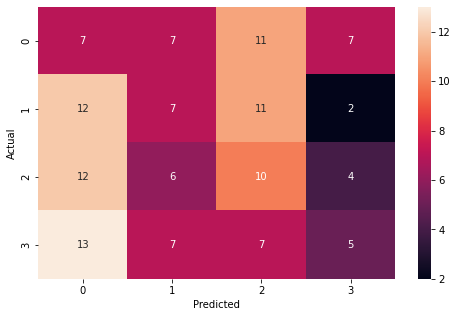

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

true_classes_model_resnet = test_set.classes
class_labels_model_resnet = list(test_set.class_indices.keys())

# Printing the classification report

print(classification_report(true_classes_model_resnet, test_pred_model_resnet_classes))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(true_classes_model_resnet, test_pred_model_resnet_classes)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f')

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

In [ ]:
trained_resnet.save('/content/drive/MyDrive/Models')

**Observations and Insights:**
**For the task we will implement a model and use Bayessian Optimization to find the best learning rate. As with transfer learning models as VGG and the implementation of resnet that obtain accurracies of 0.50 and 0.49 respectivily. Many factors can be a reason for this as the small dataset, the not so good quality of the images, the images that should not correspond to a class and other ones that make the more complex models to not perform so good as the simpler model model3. So for this dataset, for the solution it will be chosen the model3 which we implement and test in the next lines.**

In [28]:
model3.save('/content/drive/MyDrive/Models')

## **Building a Complex Neural Network Architecture**

So we choose to use a new model, the Model3 that we will implment and improve its performance, to reduce the complexity we keep using the one channel input and we reduce some layers in the model In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images for hardware purposes.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

### **Model Building**

* In this network, we plan to reduce some 7 Convolutional Blocks and 2 full  connected layers


In [8]:
######################################################



# Clearing backend

from tensorflow.keras import backend

backend.clear_session()
# Fixing the seed for random number generators

np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

#######################################################

from tensorflow.keras import regularizers
l1_l2_reg = regularizers.L1L2(l1=0.05, l2=0.025)

#######################################################

import tensorflow as tf

no_of_classes = 4

def create_model(params):
  model3 = Sequential()

  # Add 1st CNN Block
  #____________
  model3.add(Conv2D(filters = 64, kernel_size = (2, 2), activation = 'relu', padding = 'same', input_shape = (48, 48, 1)))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D((2, 2), padding = 'same'))
  model3.add(Dropout(0.2))

  # Add 2nd CNN Block
  #____________
  model3.add(Conv2D(filters = 128, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D((2, 2), padding = 'same'))
  model3.add(Dropout(0.2))

  # Add 3rd CNN Block
  #____________
  model3.add(Conv2D(filters = 512, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D((2, 2), padding = 'same'))
  model3.add(Dropout(0.2))


  # Add 4th CNN Block
  #____________
  model3.add(Conv2D(filters = 512, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Conv2D(filters = 512, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Conv2D(filters = 512, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Activation("relu"))



  #Add 5th CNN Block

  model3.add(Conv2D(filters = 256, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Conv2D(filters = 256, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Activation("relu"))


  #Add 6th CNN Block

  model3.add(Conv2D(filters = 256, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Conv2D(filters = 256, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Activation("relu"))

  # Add 7th CNN Block

  model3.add(Conv2D(filters = 256, kernel_size = (2, 2), activation = 'relu', padding = 'same'))
  model3.add(Conv2D(filters = 256, kernel_size = (2, 2), activation = 'relu', padding = 'same'))

  model3.add(Flatten())

  # First fully connected layer
  #____________

  model3.add(Dense(256, activation='relu'))
  model3.add(BatchNormalization())
  model3.add(Dense(256, activation='relu'))
  model3.add(Dropout(0.2))

  # Second fully connected layer
  #____________
  model3.add(Dense(256, activation='relu'))
  model3.add(BatchNormalization())
  model3.add(Dense(256, activation='relu'))
  model3.add(Dropout(0.2))

  model3.add(Dense(no_of_classes, activation = 'softmax'))

  model3.summary()

  opt = tf.keras.optimizers.Adam(learning_rate=0.000110599529645911)#0.0018876351674999116)#0.00002) #0.0000725) (learning rates obtained with Bayessian optimization and searchng in some ranges)
  model3.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model3


In [9]:
model3 = create_model('params')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       3

### **Compiling and Training the Model**

In [10]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 15

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0000001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [ ]:
from hyperopt import fmin, tpe, hp

space = {
 #   'units': hp.choice('units', [64, 128, 256]),  # Can customize the choices
    'learning_rate': hp.loguniform('learning_rate', -10, -5)  # Adjust the range as needed. Here the ranges were changed as looking for better spaces
}

def objective(params):
  model3 = create_model(params)
  history_model3 = model3.fit(train_set,
        steps_per_epoch=100,
        epochs=epochs,
        validation_data=validation_set,
        validation_steps=20
        )# Writing the code to fit the model. Use train_set as the training data and validation_set as the validation data. Train the model for 100 epochs.
  #Evaluate the model
  val_loss = history_model3.history['val_loss'][-1]
  return -val_loss


**BAYESSIAN OPTIMIZATION USING HYPEROPT FOR THE LEARNING RATE HYPERPARAMETER FOR MODEL 3**

In [ ]:
# Run Bayesian Optimization to find the best hyperparameters
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)  # Adjust max_evals as needed
print("Best hyperparameters:")
print(best)

Streaming output truncated to the last 5000 lines.

Epoch 4/25

100/100 [==============================] - 11s 107ms/step - loss: 1.4210 - accuracy: 0.2579 - val_loss: 1.3600 - val_accuracy: 0.3281

Epoch 5/25

100/100 [==============================] - 11s 114ms/step - loss: 1.3964 - accuracy: 0.2700 - val_loss: 1.4621 - val_accuracy: 0.1833

Epoch 6/25

100/100 [==============================] - 11s 112ms/step - loss: 1.3947 - accuracy: 0.2769 - val_loss: 1.4104 - val_accuracy: 0.2323

Epoch 7/25

100/100 [==============================] - 10s 99ms/step - loss: 1.3906 - accuracy: 0.2669 - val_loss: 1.3854 - val_accuracy: 0.2448

Epoch 8/25

100/100 [==============================] - 11s 110ms/step - loss: 1.3845 - accuracy: 0.2740 - val_loss: 1.3872 - val_accuracy: 0.2698

Epoch 9/25

100/100 [==============================] - 10s 100ms/step - loss: 1.3837 - accuracy: 0.2710 - val_loss: 1.3621 - val_accuracy: 0.2896

Epoch 10/25

100/100 [==============================] - 11s 111ms/s

In [11]:
# Writing code to compile your model3. Using categorical crossentropy as the loss function, Adam Optimizer with  learning rate 0.000110599529645911), and set metrics to 'accuracy' as start.
opt = tf.keras.optimizers.Adam(learning_rate=0.000110599529645911) #0.0018876351674999116) #0.008663720076310137) #0.0000725) At the end the best learning rate was 0.000110599529645911
model3.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

**Note:**
**Model3 was tested with different learning rates too to get the faster convergence and better performance, so learning rates tested were 0.001,0.0005, 0.000072, 0.0000725, 0.00003, 0.00002 start and Bayessian optmization was used to found even better learning rates as what is Bayessian Optimization is used in hyperparameter optimization, after Bayessian Optimization we obtained better learning rates with better results, 0.000110599529645911, #0.0018876351674999116, #0.008663720076310137, #0.0000725. In the next lines is shown 2 of the best results that were for the learning rates of 0.000110599529645911 and #0.0018876351674999116**

In [12]:
backend.clear_session() #we clean the previous session

In [13]:
epochs = 300
history_model3 = model3.fit(train_set,
        steps_per_epoch=100,
        epochs=epochs,
        validation_data=validation_set,
        validation_steps=50
        )# Writing code to fit the model. Using train_set as the training data and validation_set as the validation data. Training the model for 300 epochs.



Epoch 1/300
100/100 [==============================] - 28s 80ms/step - loss: 1.5659 - accuracy: 0.2596 - val_loss: 1.3636 - val_accuracy: 0.3754
Epoch 2/300
100/100 [==============================] - 9s 92ms/step - loss: 1.4968 - accuracy: 0.2696 - val_loss: 1.3762 - val_accuracy: 0.2383
Epoch 3/300
100/100 [==============================] - 11s 110ms/step - loss: 1.4682 - accuracy: 0.2723 - val_loss: 1.3611 - val_accuracy: 0.3617
Epoch 4/300
100/100 [==============================] - 8s 75ms/step - loss: 1.4654 - accuracy: 0.2681 - val_loss: 1.4175 - val_accuracy: 0.2458
Epoch 5/300
100/100 [==============================] - 8s 82ms/step - loss: 1.4584 - accuracy: 0.2779 - val_loss: 1.3758 - val_accuracy: 0.2454
Epoch 6/300
100/100 [==============================] - 9s 89ms/step - loss: 1.4587 - accuracy: 0.2604 - val_loss: 1.3855 - val_accuracy: 0.2275
Epoch 7/300
100/100 [==============================] - 8s 80ms/step - loss: 1.4473 - accuracy: 0.2692 - val_loss: 1.3650 - val_accura

### **Evaluating the Model on Test Set**

**Finally the model3 improved got a 0.95 accuracy showing an improving from the Resnet and VGG16 models that it was 0.50 around**

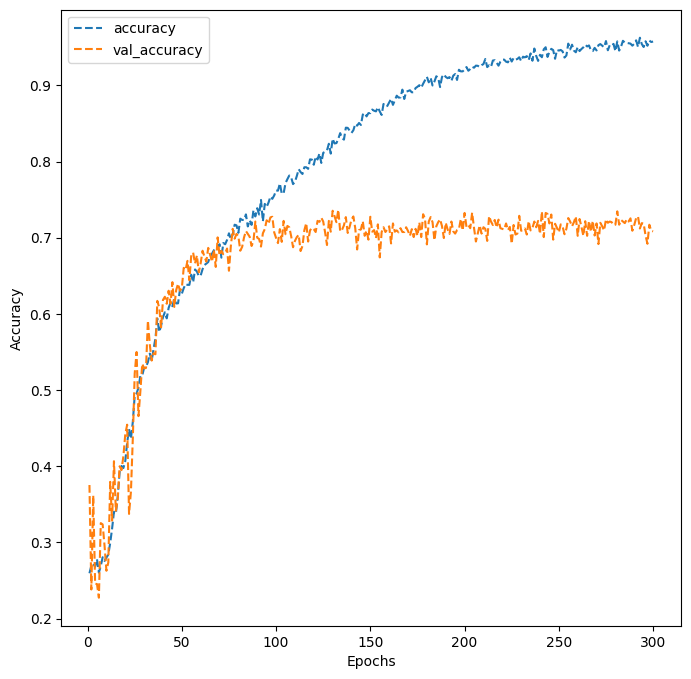

In [14]:
# Writing code to evaluate the model performance on the test set

# Plotting the accuracies

dict_hist = history_model3.history

list_ep = [i for i in range(1, 301)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        32
           1       0.66      0.59      0.62        32
           2       0.56      0.62      0.59        32
           3       0.88      0.88      0.88        32

    accuracy                           0.72       128
   macro avg       0.72      0.72      0.72       128
weighted avg       0.72      0.72      0.72       128



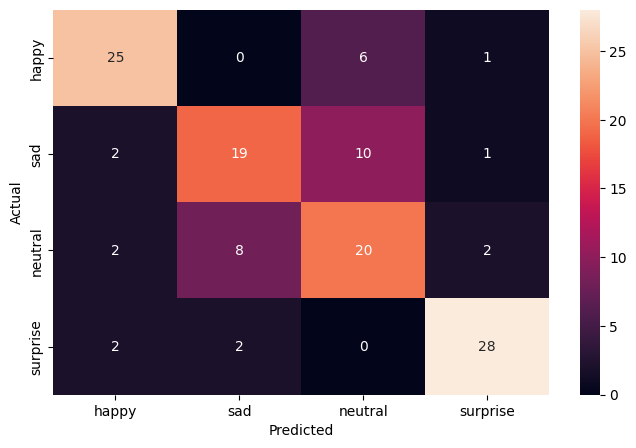

In [17]:
# Plotting the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True)
test_images, test_labels = next(test_set)

# Writing the name of the chosen model for predict
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1)
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
#_____________
print(classification_report(y_true, pred))


# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**NEXT TEST with the other learning rate 0.0018876351674999116 to show that is good but not as good as the previous one**

In [25]:
backend.clear_session()

In [26]:
model3 = create_model('params')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       3

In [27]:
# Writing code to compile model3. Using categorical crossentropy as the loss function, Adam Optimizer with 0.0018876351674999116 learning rate, and set metrics to 'accuracy'.
opt = tf.keras.optimizers.Adam(learning_rate=0.0018876351674999116) #0.000110599529645911) #0.008663720076310137) #0.0000725)
model3.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
epochs = 300
history_model3 = model3.fit(train_set,
        steps_per_epoch=100,
        epochs=epochs,
        validation_data=validation_set,
        validation_steps=50
        )# Writing code to fit the model. Using train_set as the training data and validation_set as the validation data. Training model for 300 epochs.



Epoch 1/300
100/100 [==============================] - 17s 92ms/step - loss: 1.5986 - accuracy: 0.2658 - val_loss: 1.3845 - val_accuracy: 0.3800
Epoch 2/300
100/100 [==============================] - 8s 75ms/step - loss: 1.4919 - accuracy: 0.2552 - val_loss: 1.9151 - val_accuracy: 0.2183
Epoch 3/300
100/100 [==============================] - 9s 94ms/step - loss: 1.4450 - accuracy: 0.2627 - val_loss: 1.4396 - val_accuracy: 0.2029
Epoch 4/300
100/100 [==============================] - 11s 109ms/step - loss: 1.4231 - accuracy: 0.2512 - val_loss: 1.4640 - val_accuracy: 0.2188
Epoch 5/300
100/100 [==============================] - 8s 76ms/step - loss: 1.4008 - accuracy: 0.2648 - val_loss: 1.3673 - val_accuracy: 0.2438
Epoch 6/300
100/100 [==============================] - 8s 78ms/step - loss: 1.3941 - accuracy: 0.2675 - val_loss: 1.3618 - val_accuracy: 0.3325
Epoch 7/300
100/100 [==============================] - 9s 95ms/step - loss: 1.3836 - accuracy: 0.2810 - val_loss: 1.3654 - val_accura

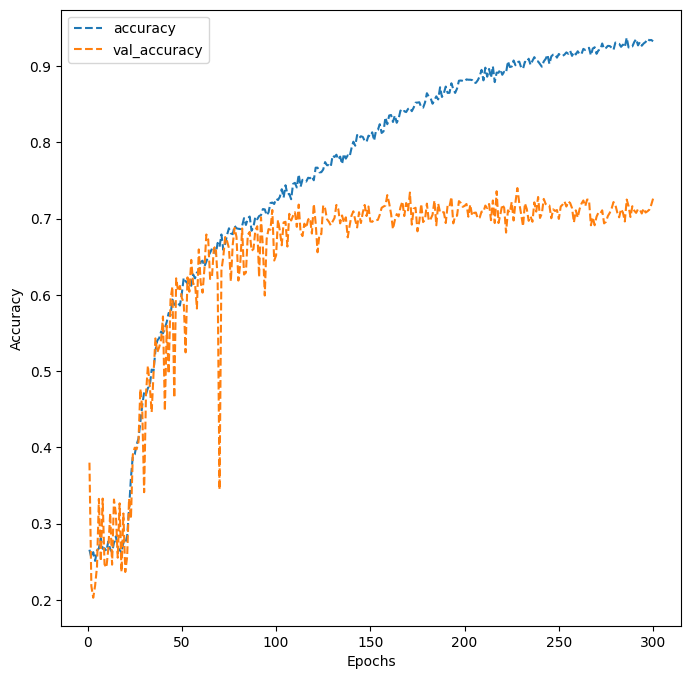

In [29]:
# Writing code to evaluate the model performance on the test set

# Plotting the accuracies

dict_hist = history_model3.history

list_ep = [i for i in range(1, 301)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

Found 128 images belonging to 4 classes.
4/4 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        32
           1       0.57      0.62      0.60        32
           2       0.56      0.62      0.59        32
           3       0.97      0.91      0.94        32

    accuracy                           0.73       128
   macro avg       0.75      0.73      0.74       128
weighted avg       0.75      0.73      0.74       128



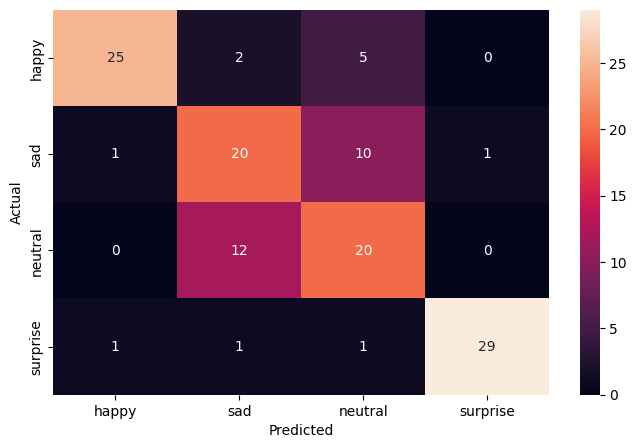

In [30]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True)
test_images, test_labels = next(test_set)

# Write the name of the chosen model to predict
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1)
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
#_____________
print(classification_report(y_true, pred))


# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## **Conclusion and Insight:**
**After training and testing different models and implementing some others the best performance one was the improved model3 with the specific learning rate selected 0.000110599529645911 obtained using Bayessian Optimization and this will be used for the solution proposed. It can show the improving in the metrics getting an accuracy of up to 0.95 and in the confussion matrix that the classification improve. It was proposed at the beggining to use transfer learning and possible aggregate models but the VGG and resnet did not perform as good as the model3, they were under 0.55 accuracy, so they won't be chosen to aggregate to the model3 as it will decrease the overall performance. Therefore only model3 was selected. Maybe a potential issue of the not so good performance of VGG and resnet (eventhought that this time converged) is the dataset that is small and no requires a higher complexity model and besides of the resolution of the images and some images that should not belong to the groups. The model3 performance could be improved using more images and adding them to the dataset and retrain to try to improve its performance. Other point to improve could be the quality of the images and to have computing power to keep training the model to test and improves the performance. It can see in the metrics the big improvement the model3 has now. And with the neutral and sad is the bigger misclassification that need to be reduced in future training of the model. the f-1 score greatly improved. This model3 will be the one selected for the final solution proposed for our task of Facial Emotion Recognition.**